# Part I - Setup & Dataset Prep
-------------------------------

## 1. Setup

In [1]:
import gzip
import json
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.1. Using Colab GPU for Training

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
!pip install transformers

     |████████████████████████████████| 675kB 2.8MB/s 
     |████████████████████████████████| 890kB 11.3MB/s 
     |████████████████████████████████| 1.1MB 13.3MB/s 
     |████████████████████████████████| 3.8MB 28.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=8582b9a6d3b752beb152229723f32468d4b641b9c502ace21a54896f7686add9
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## 2. Load Dataset

In [5]:
# Copy the model files back from Google Drive to the Colab instance. 
!cp -r "./drive/My Drive/Colab Notebooks/Insight_project/data/df.sav" ./df.sav

In [6]:
df = pickle.load(open('df.sav','rb'))

In [7]:
df

,author_name,author_rating,description,image_url,labels,num_pages,publication_year,publisher,series,title
0,,4.00,marius believes himself to be an ordinary smal...,https://images.gr-assets.com/books/1416947877m...,True,279.0,2014.0,Amy Raby,True,"Healer's Touch (Hearts And Thrones, #4)"
1,,4.00,this contains all six novels and two shorts of...,https://images.gr-assets.com/books/1380976538m...,False,2969.0,2013.0,Vamptasy Publishing,True,The Blood and Light Series (Blood and Light #1-6)
2,Katharine Boling,3.71,"an unflinching, darkly funny, and deeply movin...",https://images.gr-assets.com/books/1421247398m...,False,240.0,2012.0,Walker Childrens Hardbacks,False,A Monster Calls
3,Ou-Yang Chow Lin,4.54,asian-american superheroines evie tanaka and a...,https://images.gr-assets.com/books/1493515355m...,False,384.0,2017.0,Daw Books,True,"Heroine Worship (Heroine Complex, #2)"
4,L.T. Vargus,3.93,volume one of clive barker's seminal books of ...,https://images.gr-assets.com/books/1464920423m...,False,213.0,2015.0,"Little, Brown Book Group",True,Books of Blood 1 (Books of Blood #1)
...,...,...,...,...,...,...,...,...,...,...
83730,,4.00,librarian's note: alternate cover edition of a...,https://images.gr-assets.com/books/1433608029m...,False,342.0,2015.0,"Twelve Oakes Publishing, Inc.",True,"My Soul To Wake (Stain, #1)"
83731,Zena Kouphopoulou,4.00,"the ghost of sherlock holmes is dead, but who ...",https://s.gr-assets.com/assets/nophoto/book/11...,True,358.0,2017.0,Pan Macmillan,True,Who Killed Sherlock Holmes?
83732,Gordon Sager,4.50,"a man she'd die for, a world she was born to d...",https://images.gr-assets.com/books/1373995821m...,False,362.0,2013.0,Samhain Publishing,True,"Soul Chase (Dark Souls, #3)"
83733,,4.00,"in the city that never sleeps, spirits are equ...",https://images.gr-assets.com/books/1413258573m...,False,219.0,2014.0,Chromatic Press,False,Dead Endings


In [8]:
df.shape

(83735, 10)

## 3. Classification using book metadata

In [9]:
df_X = df[['series','num_pages','author_rating','publication_year','description']]
y = df['labels']

from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(df_X,y,test_size=0.2, random_state=2020)

In [10]:
# df_metadata = df[['series','num_pages','author_rating','publication_year']] # Best model

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [12]:
from sklearn.ensemble import AdaBoostClassifier

clf1 = AdaBoostClassifier() 
clf1.fit(X_train[['series','num_pages','author_rating','publication_year']], y_train)
y_predicted = clf1.predict(X_test[['series','num_pages','author_rating','publication_year']])
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.641, precision = 0.641, recall = 0.641, f1 = 0.641


In [13]:
# Our performance metric for the test set.
from sklearn.metrics import roc_auc_score

# Calculate the ROC AUC.
auc = roc_auc_score(y_test, y_predicted)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.641


In [14]:
y_prob_adaboost = clf1.predict_proba(X_test[['series','num_pages','author_rating','publication_year']])

In [15]:
y_prob_adaboost

array([[0.50165633, 0.49834367],
       [0.49405348, 0.50594652],
       [0.50208798, 0.49791202],
       ...,
       [0.50485534, 0.49514466],
       [0.49895361, 0.50104639],
       [0.50055676, 0.49944324]])

## 4. Classification based on book synopsis

In [16]:
import textwrap
import random

In [17]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [18]:
import numpy as np

# Tokenize all of the sentences and map the tokens to thier word IDs.
train_input_ids = []

# Record the length of each sequence (after truncating to 512).
lengths = []

print('Tokenizing synopsis...')

# For every sentence...
for sen in X_train.description:
    
    # Report progress.
    if ((len(train_input_ids) % 20000) == 0):
        print('  Read {:,} synopsis.'.format(len(train_input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 512,          # Truncate all sentences.                        
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    train_input_ids.append(encoded_sent)

    # Record the truncated length.
    lengths.append(len(encoded_sent))

print('DONE.')
print('{:>10,} synopsis'.format(len(train_input_ids)))

Token indices sequence length is longer than the specified maximum sequence length for this model (1097 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


Tokenizing synopsis...
  Read 0 synopsis.


Token indices sequence length is longer than the specified maximum sequence length for this model (811 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (697 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

  Read 20,000 synopsis.


Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (819 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

  Read 40,000 synopsis.


Token indices sequence length is longer than the specified maximum sequence length for this model (644 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (512 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1091 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (797 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

  Read 60,000 synopsis.


Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (775 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

DONE.
    66,988 synopsis


In [19]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the required sequence length.
MAX_LEN = 300

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 300 values...

Padding token: "[PAD]", ID: 0


Using TensorFlow backend.



Done.


In [20]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in train_input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [21]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_input_ids, y_train.to_numpy().astype(int), 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, y_train.to_numpy().astype(int),
                                             random_state=2018, test_size=0.1)

In [22]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [23]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Part II - BERT Fine-Tuning

In [24]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
                    # If you set this to 1, it will train a regression model!!!
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [25]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [26]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [27]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [29]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch   100  of  1,885.    Elapsed: 0:01:33.
  Batch   200  of  1,885.    Elapsed: 0:03:06.
  Batch   300  of  1,885.    Elapsed: 0:04:39.
  Batch   400  of  1,885.    Elapsed: 0:06:12.
  Batch   500  of  1,885.    Elapsed: 0:07:45.
  Batch   600  of  1,885.    Elapsed: 0:09:18.
  Batch   700  of  1,885.    Elapsed: 0:10:51.
  Batch   800  of  1,885.    Elapsed: 0:12:24.
  Batch   900  of  1,885.    Elapsed: 0:13:57.
  Batch 1,000  of  1,885.    Elapsed: 0:15:29.
  Batch 1,100  of  1,885.    Elapsed: 0:17:02.
  Batch 1,200  of  1,885.    Elapsed: 0:18:35.
  Batch 1,300  of  1,885.    Elapsed: 0:20:09.
  Batch 1,400  of  1,885.    Elapsed: 0:21:42.
  Batch 1,500  of  1,885.    Elapsed: 0:23:15.
  Batch 1,600  of  1,885.    Elapsed: 0:24:48.
  Batch 1,700  of  1,885.    Elapsed: 0:26:21.
  Batch 1,800  of  1,885.    Elapsed: 0:27:54.

  Average training loss: 0.67
  Training epcoh took: 0:29:12

Running Validation...
  Accuracy: 0.61
  Validat

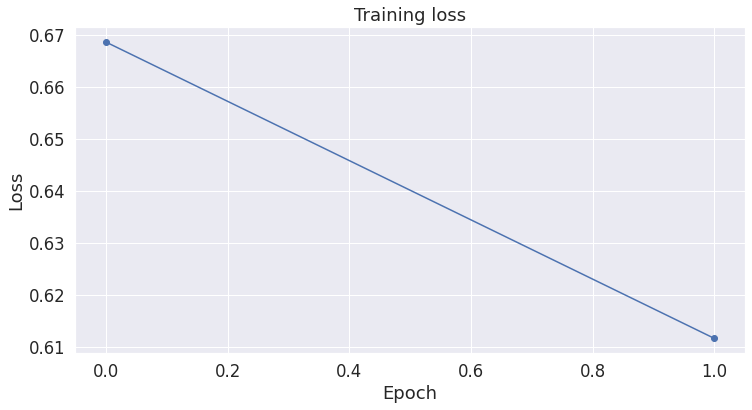

In [30]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### Now get BERT prediction outputs on the test set

In [31]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []

# For every sentence...
for sen in X_test.description:
    
    # Report progress.
    if ((len(test_input_ids) % 20000) == 0):
        print('  Read {:,} synopsis.'.format(len(test_input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,          # Truncate all sentences.                        
                   )
    
    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_sent)

print('DONE.')
print('')
print('{:>10,} test synopsis'.format(len(test_input_ids)))

# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
test_labels = y_test.to_numpy().astype(int)

print('{:>10,} positive (popular)'.format(np.sum(test_labels)))
print('{:>10,} negative (not popular)'.format(len(test_labels) - np.sum(test_labels)))

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                               dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask) 

# Convert to tensors.
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

  Read 0 synopsis.
DONE.

    16,747 test synopsis
     8,426 positive (popular)
     8,321 negative (not popular)


In [32]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 16,747 test sentences...
  Batch   100  of    524.    Elapsed: 0:00:30.
  Batch   200  of    524.    Elapsed: 0:01:00.
  Batch   300  of    524.    Elapsed: 0:01:29.
  Batch   400  of    524.    Elapsed: 0:01:59.
  Batch   500  of    524.    Elapsed: 0:02:29.
    DONE.


In [33]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [34]:
predictions[0:10]

array([[ 0.13969946,  0.05002119],
       [-0.02776944,  0.14133294],
       [ 0.7098064 , -0.5230947 ],
       [-0.40086257,  0.4533605 ],
       [-0.12935781,  0.3304236 ],
       [ 0.86926895, -0.46115512],
       [ 0.15304357,  0.04559207],
       [-0.13476986,  0.26107496],
       [-0.02788475,  0.1894153 ],
       [-0.47589117,  0.48503113]], dtype=float32)

In [35]:
import torch.nn.functional as F 

y_prob_BERT = []
for i in range(len(predictions)):
  row = predictions[i]
  row = F.softmax(torch.tensor(row))
  y_prob_BERT.append(row.numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [36]:
len(y_prob_BERT)
y_prob_BERT[0].argmax(0)

y_class_BERT = []
for i in range(len(y_prob_BERT)):
  y_class_BERT.append(y_prob_BERT[i].argmax(0))

y_class_BERT[0:10]

[0, 1, 0, 1, 1, 0, 0, 1, 1, 1]

In [37]:
true_labels[0:10]

array([0, 1, 1, 1, 0, 0, 1, 0, 0, 1])

In [38]:
# Our performance metric for the test set.
from sklearn.metrics import roc_auc_score

# # Use the model output for label 1 as our predictions.
# p1 = predictions[:,1]

# Calculate the ROC AUC.
auc = roc_auc_score(y_test,y_class_BERT)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.629


In [39]:
flat_accuracy(predictions, true_labels)

0.6296650146294859

In [40]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_class_BERT)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.630, precision = 0.632, recall = 0.630, f1 = 0.628


## Save Trained Model

In [41]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = '/content/drive/My Drive/Colab Notebooks/Insight_project/model/model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to /content/drive/My Drive/Colab Notebooks/Insight_project/model/model_save/


('/content/drive/My Drive/Colab Notebooks/Insight_project/model/model_save/vocab.txt',
 '/content/drive/My Drive/Colab Notebooks/Insight_project/model/model_save/special_tokens_map.json',
 '/content/drive/My Drive/Colab Notebooks/Insight_project/model/model_save/added_tokens.json')

In [42]:
gdrive_path = "./drive/My Drive/Colab Notebooks/Insight_project/model/model_save/"

# Create output directory if needed
if not os.path.exists(gdrive_path):
    os.makedirs(gdrive_path)

# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/Colab Notebooks/Insight_project/model/model_save/"

cp: cannot stat './model_save/': No such file or directory


In [43]:
# pickle.dump(train_predictions,open('train_predictions.sav','wb'))
# !cp -r train_predictions.sav "./drive/My Drive/Colab Notebooks/model_save/"

# Part III - Voting Classifier

In [44]:
y_prob_adaboost[0:10]

array([[0.50165633, 0.49834367],
       [0.49405348, 0.50594652],
       [0.50208798, 0.49791202],
       [0.4975617 , 0.5024383 ],
       [0.50036758, 0.49963242],
       [0.50149244, 0.49850756],
       [0.49425021, 0.50574979],
       [0.4998893 , 0.5001107 ],
       [0.50149244, 0.49850756],
       [0.49941069, 0.50058931]])

In [45]:
y_prob_BERT[0:10]

[array([0.52240455, 0.47759545], dtype=float32),
 array([0.45782486, 0.5421751 ], dtype=float32),
 array([0.7743259 , 0.22567408], dtype=float32),
 array([0.29854771, 0.70145226], dtype=float32),
 array([0.3870377, 0.6129623], dtype=float32),
 array([0.7909107 , 0.20908922], dtype=float32),
 array([0.52683705, 0.47316295], dtype=float32),
 array([0.40231106, 0.5976889 ], dtype=float32),
 array([0.44588774, 0.55411226], dtype=float32),
 array([0.27669355, 0.7233064 ], dtype=float32)]

In [46]:
# Soft voting classifier on the 2 base models
y_prob_total = y_prob_adaboost + y_prob_BERT
y_class_total = y_prob_total[:,1]>y_prob_total[:,0]

In [47]:
y_prob_total[0:10]

array([[1.02406088, 0.97593912],
       [0.95187834, 1.04812163],
       [1.27641389, 0.72358609],
       [0.79610941, 1.20389056],
       [0.88740527, 1.11259473],
       [1.29240316, 0.70759678],
       [1.02108726, 0.97891274],
       [0.90220035, 1.09779962],
       [0.94738019, 1.05261981],
       [0.77610425, 1.22389572]])

In [48]:
y_class_total[0:10]

array([False,  True, False,  True,  True, False, False,  True,  True,
        True])

In [49]:
# Calculate the ROC AUC.
auc = roc_auc_score(y_test,y_class_total)

print('Test ROC AUC: %.3f' %auc)

Test ROC AUC: 0.630


In [50]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_class_total)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.630, precision = 0.633, recall = 0.630, f1 = 0.628


# Part IV - Combined XGBoost model

### Now get BERT prediction outputs on the traning set

In [61]:
train_synopsis = pd.DataFrame(X_train)
train_synopsis['popular'] = y_train

In [63]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
train_input_ids = []

# For every sentence...
for sen in train_synopsis.description:
    
    # Report progress.
    if ((len(train_input_ids) % 20000) == 0):
        print('  Read {:,} synopsis.'.format(len(train_input_ids)))
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,          # Truncate all sentences.                        
                   )
    
    # Add the encoded sentence to the list.
    train_input_ids.append(encoded_sent)

print('DONE.')
print('')
print('{:>10,} test synopsis'.format(len(train_input_ids)))

# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
train_labels = train_synopsis.popular.to_numpy().astype(int)

print('{:>10,} positive (popular)'.format(np.sum(train_labels)))
print('{:>10,} negative (not popular)'.format(len(train_labels) - np.sum(train_labels)))

# Pad our input tokens
train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, 
                               dtype="long", truncating="post", padding="post")

# Create attention masks
train_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in train_input_ids:
  seq_mask = [float(i>0) for i in seq]
  train_attention_masks.append(seq_mask) 

# Convert to tensors.
train_inputs = torch.tensor(train_input_ids)
train_masks = torch.tensor(train_attention_masks)
train_labels = torch.tensor(train_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  Read 0 synopsis.
  Read 20,000 synopsis.
  Read 40,000 synopsis.
  Read 60,000 synopsis.
DONE.

    66,988 test synopsis
    33,425 positive (popular)
    33,563 negative (not popular)


In [64]:
# Prediction on train set

print('Predicting labels for {:,} train sentences...'.format(len(train_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
train_predictions , train_true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(train_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    train_predictions.append(logits)
    train_true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 66,988 train sentences...
  Batch   100  of  2,094.    Elapsed: 0:00:30.
  Batch   200  of  2,094.    Elapsed: 0:00:59.
  Batch   300  of  2,094.    Elapsed: 0:01:29.
  Batch   400  of  2,094.    Elapsed: 0:01:59.
  Batch   500  of  2,094.    Elapsed: 0:02:28.
  Batch   600  of  2,094.    Elapsed: 0:02:58.
  Batch   700  of  2,094.    Elapsed: 0:03:28.
  Batch   800  of  2,094.    Elapsed: 0:03:57.
  Batch   900  of  2,094.    Elapsed: 0:04:27.
  Batch 1,000  of  2,094.    Elapsed: 0:04:56.
  Batch 1,100  of  2,094.    Elapsed: 0:05:26.
  Batch 1,200  of  2,094.    Elapsed: 0:05:56.
  Batch 1,300  of  2,094.    Elapsed: 0:06:25.
  Batch 1,400  of  2,094.    Elapsed: 0:06:55.
  Batch 1,500  of  2,094.    Elapsed: 0:07:25.
  Batch 1,600  of  2,094.    Elapsed: 0:07:54.
  Batch 1,700  of  2,094.    Elapsed: 0:08:24.
  Batch 1,800  of  2,094.    Elapsed: 0:08:54.
  Batch 1,900  of  2,094.    Elapsed: 0:09:23.
  Batch 2,000  of  2,094.    Elapsed: 0:09:53.
    DONE.


In [65]:
# Combine the results across the batches.
train_predictions = np.concatenate(train_predictions, axis=0)
train_true_labels = np.concatenate(train_true_labels, axis=0)

In [66]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


accuracy = 0.664, precision = 0.664, recall = 0.664, f1 = 0.664
Test ROC AUC: 0.664


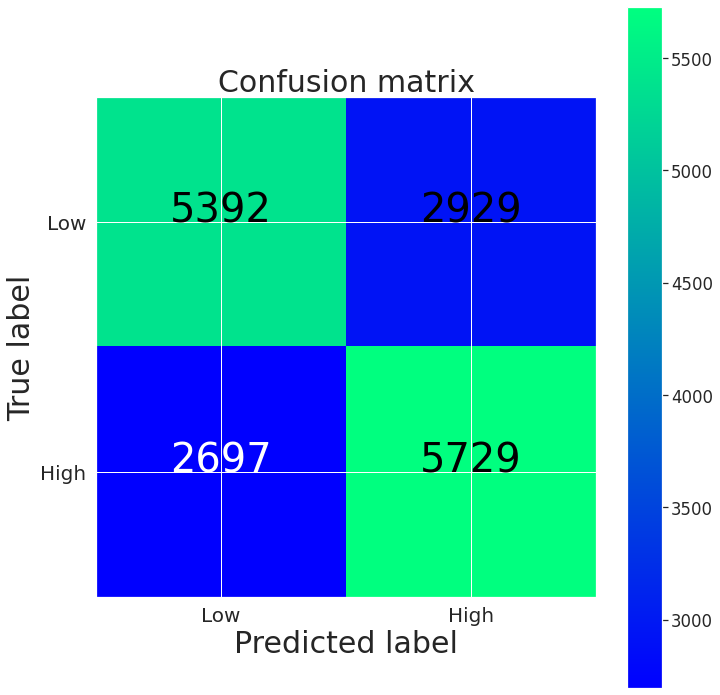

In [71]:
# from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
# from sklearn.linear_model import LogisticRegression

X_train['BERT_result'] = train_predictions[:,1]
X_test['BERT_result'] = predictions[:,1]

clf = XGBClassifier()
# clf = AdaBoostClassifier() 
# clf = LogisticRegression()
clf.fit(X_train[['series','num_pages','author_rating','publication_year','BERT_result']], y_train)
y_predicted = clf.predict(X_test[['series','num_pages','author_rating','publication_year','BERT_result']])
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

auc = roc_auc_score(y_test, y_predicted)
print('Test ROC AUC: %.3f' %auc)

cm = confusion_matrix(y_test, y_predicted)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Low','High'], normalize=False, title='Confusion matrix')
plt.show()

In [70]:
clf.feature_importances_

array([0.16951774, 0.05775862, 0.01544239, 0.1217733 , 0.635508  ],
      dtype=float32)

In [ ]:
# clf.save_model('alldata_xgboost_clf.model')
# pickle.dump(clf,open('alldata_xgboost_clf.dat','wb'))

In [ ]:
# Copy the embeddings to a directory in your Google Drive.
# !cp -r alldata_xgboost_clf.dat "./drive/My Drive/Colab Notebooks/model_save/"